In [1]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from matplotlib.colors import ListedColormap
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_random_state

In [2]:
from typing import NamedTuple, Optional
from sklearn import datasets

class DataSet(NamedTuple):
    train_data: Optional[np.ndarray]
    train_target: Optional[np.ndarray]
    validation_data: Optional[np.ndarray]
    validation_target: Optional[np.ndarray]
    test_data: Optional[np.ndarray]
    test_target: Optional[np.ndarray]

In [3]:
def generate(dataset, **dataset_params) -> DataSet:
    train_size = dataset_params.pop("train_size", 50)
    val_size = dataset_params.pop("val_size", 50)
    test_size = dataset_params.pop("test_size", 50)

    if dataset == "circles":
        x, y = datasets.make_circles(n_samples=train_size + val_size + test_size, random_state=1337, **dataset_params)
    elif dataset == "moons":
        x, y = datasets.make_moons(n_samples=train_size + val_size + test_size, random_state=1337, **dataset_params)
    elif dataset == "classification":
        x, y = datasets.make_classification(n_samples=train_size + val_size + test_size, random_state=1337, **dataset_params)
    elif dataset == "blobs":
        x, y = datasets.make_blobs(n_samples=train_size + val_size + test_size, random_state=1337, **dataset_params)
    elif dataset == "Gaussian":
        x, y = Gaussian_dist(100)
    else:
        raise ValueError(f"Unknown dataset: {dataset}")

    x_train, y_train = x[:train_size], y[:train_size]
    x_val, y_val = x[train_size:train_size+val_size], y[train_size:train_size+val_size]
    x_test, y_test = x[train_size+val_size:train_size+val_size+test_size], y[train_size+val_size:train_size+val_size+test_size]
    #x_test, y_test = x[100:100+test_size], y[100:100+test_size]

    return DataSet(x_train, y_train, x_val, y_val, x_test, y_test)


In [4]:
data = generate('moons', train_size=30, val_size=10, test_size=100, noise=0.0)
# Access train, validation, and test splits
x_train = data.train_data
y_train = data.train_target

x_val = data.validation_data
y_val = data.validation_target

x_test = data.test_data
y_test = data.test_target

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(30, 2)
(30,)
(10, 2)
(10,)
(100, 2)
(100,)


In [6]:
def normalize_to_pi(data):
    """Normalize to [-π, π] range instead of [0, 2π]"""
    min_val = np.min(data)
    max_val = np.max(data)
    return np.pi * (2 * (data - min_val) / (max_val - min_val) - np.pi)

x_train_normalize = normalize_to_pi(x_train)
x_val_normalize = normalize_to_pi(x_val)
x_test_normalize = normalize_to_pi(x_test)

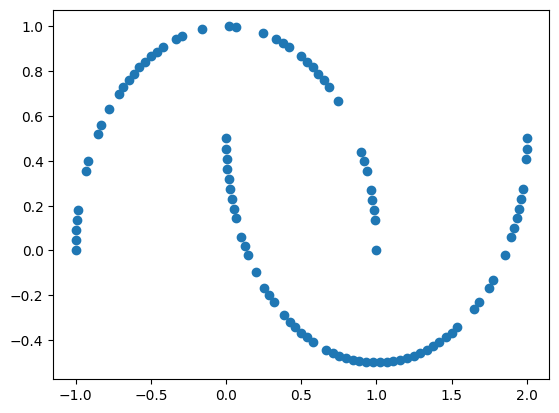

In [7]:
plt.scatter(x_test[:, 0], x_test[:, 1])

In [8]:
from Qkernel import QKernel

In [9]:
def get_cost_func(X, Y, cost_func_params, qkernel, n_clusters=None):
    """
    Constructs the cost function for training the quantum kernel using target alignment.
    """
    return lambda params: -qml.kernels.target_alignment(
        X, Y,
        kernel=lambda x1, x2: qkernel.kernel_circuit(x1, x2, params)[0],
        **cost_func_params
    )

In [10]:
def train_kernel(X, Y, qkernel, cost_func_params={},
                 n_clusters=None, steps=100, lr=0.1, verbose=True):
    """
    Trains the variational quantum kernel by minimizing the negative alignment.
    Stores kernel matrices at every 10 steps in a dictionary.
    """
    params = qkernel.params.copy()
    cost_fn = get_cost_func(X, Y, cost_func_params, qkernel, n_clusters)
    
    opt = qml.AdamOptimizer(lr)
    loss_history = []
    kernel_matrices = {}  # Dictionary to store kernel matrices


    for step in range(steps):
        params, loss = opt.step_and_cost(cost_fn, params)
        loss_history.append(loss)

        if verbose and step % 10 == 0:
            print(f"Step {step:3d} | Loss: {loss:.6f}")
            
            # # Compute and store kernel matrix every 10 steps
            # trained_kernel = lambda x1, x2: qkernel.kernel_circuit(x1, x2, params)[0]
            # K = qml.kernels.square_kernel_matrix(data, trained_kernel)
            # kernel_matrices[step] = K  

    return params, loss_history

In [11]:
from Ansatz import Ansatz2, Ansatz, ImprovedAnsatz

In [12]:
# 1. Instantiate QKernel 
qkernel = QKernel(
    num_wires=4,
    ansatz = ImprovedAnsatz,
    num_layers=3,                
    device_name="default.qubit",  
    shots=None                    
)

# 2. Train the kernel
t_params, loss = train_kernel(
    X=x_train_normalize,
    Y=y_train,
    qkernel=qkernel,
    steps=70,
    lr=0.1,
    verbose=True
)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [13]:
from sklearn.cluster import SpectralClustering
    

# Clustering using the kernel
clustering_K = SpectralClustering(
    n_clusters=2,
    affinity='precomputed',
    #kernel_params = params
)

In [14]:
# Compute and store kernel matrix every 10 steps
trained_kernel = lambda x1, x2: qkernel.kernel_circuit(x1, x2, t_params)[0]
K = qml.kernels.square_kernel_matrix(x_test_normalize, trained_kernel)

In [31]:
K.shape

(100, 100)

In [15]:
from sklearn.manifold import MDS

def plot_kernel(kernel_mat, y_test):
    embedding = MDS(n_components=2, dissimilarity="precomputed")
    dissimilarities = 1 - kernel_mat
    X_transformed = embedding.fit_transform(dissimilarities, y_test)

    fig, ax = plt.subplots()
    ax.scatter(X_transformed[:,0], X_transformed[:,1], c=y_test)
    ax.set_ylim([-1,1])
    ax.set_xlim([-1,1])

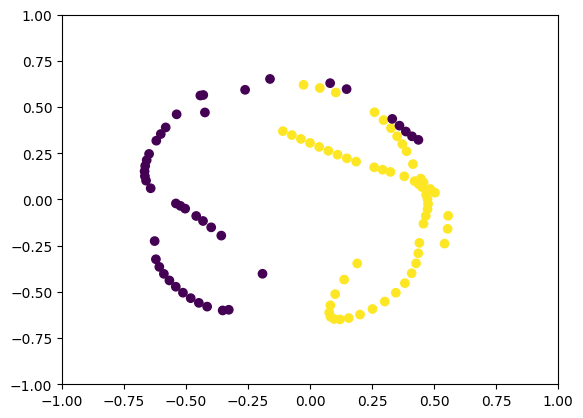

In [16]:
plot_kernel(K, y_test)

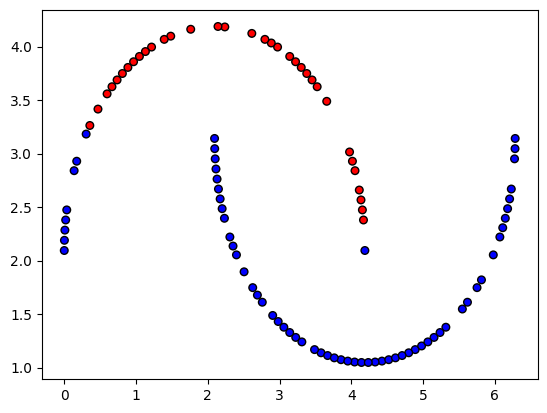

In [17]:
from sklearn.cluster import SpectralClustering

# Clustering using the kernel
clustering_K = SpectralClustering(
    n_clusters=2,
    affinity='precomputed',
    #kernel_params = params
)
from matplotlib.colors import ListedColormap

labels_K = clustering_K.fit_predict(K)
cmap = ListedColormap(['#FF0000', '#0000FF'])  # Red for cluster 1, Blue for cluster 2

plt.scatter(x_test_normalize[:, 0], x_test_normalize[:, 1], c=labels_K, cmap=cmap, s=30, edgecolor='k')